In [13]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data = {self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out
        
    def __radd__(self, other):
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
        
    def __rmul__(self, other):
        return self * other
        
    def __neg__(self):
        return -1 * self
        
    def __sub__(self, other):
        return self + (-other)
        
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Can only accept int or float"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += out.grad * other * self.data**(other - 1)
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        return self * other**-1
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += out.grad * (1-t**2)
        out._backward = _backward
        return out
        
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        for node in reversed(topo):
            node._backward()

In [15]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for (n1, n2) in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [16]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2 (synaptic strings for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
# cell body raw activation without the activation function (tanh)
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o' 

o.backward()

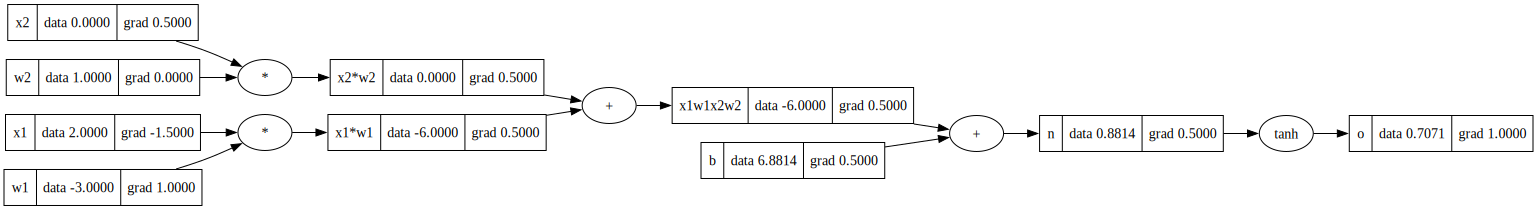

In [17]:
draw_dot(o)

In [18]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)
o.backward()

print(f"o.data = {o.data.item()}")
print('_____')
print(f"x1.grad = {x1.grad.item()}")
print(f"x2.grad = {x2.grad.item()}")
print(f"w1.grad = {w1.grad.item()}")
print(f"w2.grad = {w2.grad.item()}")

o.data = 0.7071066904050358
_____
x1.grad = -1.5000003851533106
x2.grad = 0.5000001283844369
w1.grad = 1.0000002567688737
w2.grad = 0.0


In [26]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out
        
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [27]:
# building neural net
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
out = n(x)

In [34]:
def train_neural_net(xs, ys):
    ypred = []
    loss = None
    for k in range(10):
        # zero grad
        for p in n.parameters():
            p.grad = 0.0
        # forward pass
        ypred = [n(x) for x in xs]
        # calculate loss
        loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
        # backward pass
        loss.backward()
        # gradient descent
        for p in n.parameters():
            p.data += -0.1 * p.grad
        print(f"Step = {k} and loss = {loss}")
    return ypred, loss

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
] # 4 possible inputs to the neural net
ys = [1.0, -1.0, -1.0, 1.0] # 4 desired targets
ypred, loss = train_neural_net(xs, ys)
print(f"Predictions = {ypred}")

Step = 0 and loss = Value(data = 0.0007852050018190038)
Step = 1 and loss = Value(data = 0.0007833249617113388)
Step = 2 and loss = Value(data = 0.0007814538141859385)
Step = 3 and loss = Value(data = 0.0007795914965773221)
Step = 4 and loss = Value(data = 0.0007777379468058866)
Step = 5 and loss = Value(data = 0.0007758931033711041)
Step = 6 and loss = Value(data = 0.0007740569053447991)
Step = 7 and loss = Value(data = 0.0007722292923645351)
Step = 8 and loss = Value(data = 0.0007704102046270007)
Step = 9 and loss = Value(data = 0.0007685995828816719)
Predictions = [Value(data = 0.9895889826456749), Value(data = -0.9903112107015347), Value(data = -0.982208960717813), Value(data = 0.9841944128954588)]
